In [65]:
import pandas as pd
import optuna
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from preprocessing import *

import gc

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
categorical_cols = [
    "Gender",
    "Driving_License",
    "Region_Code",
    "Previously_Insured",
    "Vehicle_Age",
    "Vehicle_Damage",
    "Policy_Sales_Channel",
    "Response",
]

for df in [train_df, test_df]:
    for col in categorical_cols:
        try:
            df[col] = df[col].astype("category")
        except:
            continue

    df["Age"] = df["Age"].astype("int8")
    df["Region_Code"] = df["Region_Code"].astype("int8")
    df["Annual_Premium"] = df["Annual_Premium"].astype("int32")
    df["Vintage"] = df["Vintage"].astype("int16")

    df["Gender"] = df["Gender"].cat.rename_categories({"Female":0, "Male":1})
    df["Vehicle_Age"] = df["Vehicle_Age"].cat.rename_categories({"< 1 Year":0, "1-2 Year":1, "> 2 Years":2})
    df["Vehicle_Damage"] = df["Vehicle_Damage"].cat.rename_categories({"No":0, "Yes":1})

    # df["Not_Insured_and_Damaged"] = (df["Previously_Insured"] == 0) & (df["Vehicle_Damage"] == 1)
    # df["Not_Insured_and_Damaged"] = df["Not_Insured_and_Damaged"].astype("int8")
    feature_engineer(df, [FE_OPTS.Not_Insured_and_Damaged, FE_OPTS.Age_Discriminator])

# sample_weights = compute_sample_weight(class_weight="balanced", y=train_df["Response"])

In [4]:
def undersample(df):
    zeroes = df[df["Response"] == 0]
    ones = df[df["Response"] == 1]
    undersampled_zeroes = zeroes.sample(len(ones))

    downsampled_df = pd.concat([ones, undersampled_zeroes])
    zeroes = None
    ones = None
    gc.collect()
    return downsampled_df

def decimate(df, frac=0.01):
    return df.groupby("Response", group_keys=False, observed=False).apply(lambda x: x.sample(frac=frac))

In [26]:
def cross_val_scores_weighted(model, X, y, weights, kf, metrics=[accuracy_score]):
    scores = [[] for metric in metrics]

    for train_index, test_index in kf.split(X, y):
        model_clone = sklearn.base.clone(model)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        weights_train, weights_test = weights[train_index], weights[test_index]

        model_clone.fit(X_train, y_train, sample_weight=weights_train)
        y_pred = model_clone.predict(X_test)

        for i, metric in enumerate(metrics):
            score = metric(y_test, y_pred, sample_weight=weights_test)
            scores[i].append(score)

    return scores

In [70]:
class ObjectiveCV(object):
    def __init__(self, train_set, kfold, n_jobs, random_state=0):
        self.train = train_set
        self.kfold = kfold
        self.n_jobs = n_jobs

        self.random_state = random_state

    def __model_logreg(self, trial):
        penalty = trial.suggest_categorical("penalty", [None, "l1", "l2", "elasticnet"])
        logreg_c = trial.suggest_int("logreg_c", 1, 100)

        if penalty == "elasticnet":
            l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
            clf = LogisticRegression(
                random_state=self.random_state,
                n_jobs=self.n_jobs,
                penalty=penalty,
                C=logreg_c,
                l1_ratio=l1_ratio,
                solver="saga",
                max_iter=int(1e5)
            )

        else:
            clf = LogisticRegression(
                random_state=self.random_state,
                n_jobs=self.n_jobs,
                penalty=penalty,
                C=logreg_c,
                solver="saga",
                max_iter=int(1e5)
            )

        return clf

    def __model_rf(self, trial):
        # bootstrap = trial.suggest_categorical("bootstrap", [True, False])
        # max_sample = None
        # if bootstrap:
        #     max_sample = trial.suggest_float("max_samples", 0, 1)

        return RandomForestClassifier(
            random_state=self.random_state,
            n_jobs=self.n_jobs,

            n_estimators=trial.suggest_int("n_estimators", 100, 4e3),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            min_samples_split=trial.suggest_float("min_samples_split", 0, 0.5),
            min_samples_leaf=trial.suggest_float("min_samples_leaf", 0, 0.3),
            min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0, 0.3),
            max_features=trial.suggest_float("max_features", 0, 1),
            # max_leaf_nodes=trial.suggest_int("mlf", 0, 5e3),
            # min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 5e3),
            # bootstrap=bootstrap,
            # warm_start=trial.suggest_categorical("warm_start", [True, False]),
            # max_samples=max_sample,
            # ccp_alpha=trial.suggest_float("ccp_alpha", 0, 5e3),
        )

    def __model_xgb(self, trial):
        return XGBClassifier(
            enable_categorical=True,
            random_state=self.random_state,
            n_jobs=self.n_jobs,

            n_estimators=trial.suggest_int("n_estimators", 1, 1e4),
            eta=trial.suggest_float("eta", 0.01, 1),
            gamma=trial.suggest_float("gamma", 0, 20),
            max_depth=trial.suggest_int("max_depth", 3, 10, step=1),
            max_leaves=trial.suggest_int("max_leaves", 0, 1e4),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.05, 1),
            colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1),
            colsample_bynode=trial.suggest_float("colsample_bynode", 0.05, 1),
            reg_lambda=trial.suggest_int("reg_lambda", 0, 20),
            reg_alpha=trial.suggest_int("reg_alpha", 0, 20),
            grow_policy=trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            ),
            min_child_weight=trial.suggest_float("min_child_weight", 0, 1e3),
            max_delta_step=trial.suggest_float("max_delta_step", 0, 1e2)
        )

    def init_model(self, trial, use_models=["logreg", "random_forest", "xgboost"]):
        clf_selector = {
            "logreg": self.__model_logreg,
            "random_forest": self.__model_rf,
            "xgboost": self.__model_xgb,
        }

        return clf_selector[
            trial.suggest_categorical(
                "classifier", use_models
            )
        ](trial)

    def __call__(self, trial):
        use_models = ["xgboost"]
        model = self.init_model(trial, use_models=use_models)

        x = self.train.drop(columns=["Response"])
        y = self.train["Response"]

        # if trial.suggest_categorical("weighted_samples", [True, False]):
        sample_weights = compute_sample_weight(class_weight="balanced", y=y)
        metrics = [roc_auc_score]

        scores = cross_val_scores_weighted(
            model,
            x,
            y,
            sample_weights,
            self.kfold,
            metrics=metrics
        )
        scores = scores[0]
        # else:
        #     scores = cross_val_score(
        #         model,
        #         x,
        #         y,
        #         scoring="roc_auc",
        #         cv=self.kfold,
        #         n_jobs=self.n_jobs,
        #         error_score="raise",
        #     )

        return np.mean(scores)

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# optuna.delete_study(study_name="xgb_exploration_v1", storage="sqlite:///optuna.sqlite3")

# study = optuna.create_study(
#     direction="maximize",
#     storage="sqlite:///optuna.sqlite3",
#     study_name="classifiers_simple",
#     load_if_exists=True
# )

study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///optuna.sqlite3",
    study_name="xgb_force_weighted_v1",
    load_if_exists=True
)
objective = ObjectiveCV(decimated_df, skf, n_jobs=8)

study.optimize(objective, n_trials=100)
gc.collect()

[I 2024-07-29 17:00:40,645] A new study created in RDB with name: xgb_force_weighted_v1
[I 2024-07-29 17:00:55,970] Trial 0 finished with value: 0.8009396058338026 and parameters: {'classifier': 'xgboost', 'n_estimators': 4643, 'eta': 0.2595795447781648, 'gamma': 19.620022085024576, 'max_depth': 3, 'max_leaves': 1784, 'colsample_bytree': 0.43399940816291827, 'colsample_bylevel': 0.6656506054387087, 'colsample_bynode': 0.09427536818224719, 'reg_lambda': 19, 'reg_alpha': 5, 'grow_policy': 'lossguide', 'min_child_weight': 542.3004699294117, 'max_delta_step': 56.96481080396036}. Best is trial 0 with value: 0.8009396058338026.
[I 2024-07-29 17:01:14,257] Trial 1 finished with value: 0.8004736134757087 and parameters: {'classifier': 'xgboost', 'n_estimators': 5304, 'eta': 0.7747920037913099, 'gamma': 6.590983671635103, 'max_depth': 3, 'max_leaves': 1688, 'colsample_bytree': 0.3233318625927542, 'colsample_bylevel': 0.35273894736686073, 'colsample_bynode': 0.6225835323617728, 'reg_lambda': 12,

25912

In [72]:
study.best_params

{'classifier': 'xgboost',
 'n_estimators': 7760,
 'eta': 0.8207447316007527,
 'gamma': 0.28522702133302263,
 'max_depth': 5,
 'max_leaves': 9729,
 'colsample_bytree': 0.12780348072654993,
 'colsample_bylevel': 0.8029529463526536,
 'colsample_bynode': 0.8653741499709178,
 'reg_lambda': 7,
 'reg_alpha': 1,
 'grow_policy': 'lossguide',
 'min_child_weight': 206.24409808086375,
 'max_delta_step': 61.72394262677851}

In [73]:
best_model = XGBClassifier(enable_categorical=True, random_state=0, n_jobs=-1,
    eta=study.best_params["eta"],
    gamma=study.best_params["gamma"],
    max_depth=study.best_params["max_depth"],
    colsample_bytree=study.best_params["colsample_bytree"],
    colsample_bylevel=study.best_params["colsample_bylevel"],
    colsample_bynode=study.best_params["colsample_bynode"],
    reg_lambda=study.best_params["reg_lambda"],
    reg_alpha=study.best_params["reg_alpha"],
    grow_policy=study.best_params["grow_policy"],
    device="cuda"
)
x, y = train_df.drop(columns=["Response"]), train_df["Response"]
best_model.fit(x, y)
xgb_preds = best_model.predict(x)

In [74]:
xgb_preds = pd.DataFrame({"preds":xgb_preds})
xgb_preds.groupby("preds").value_counts()

preds
0    11316100
1      188698
Name: count, dtype: int64

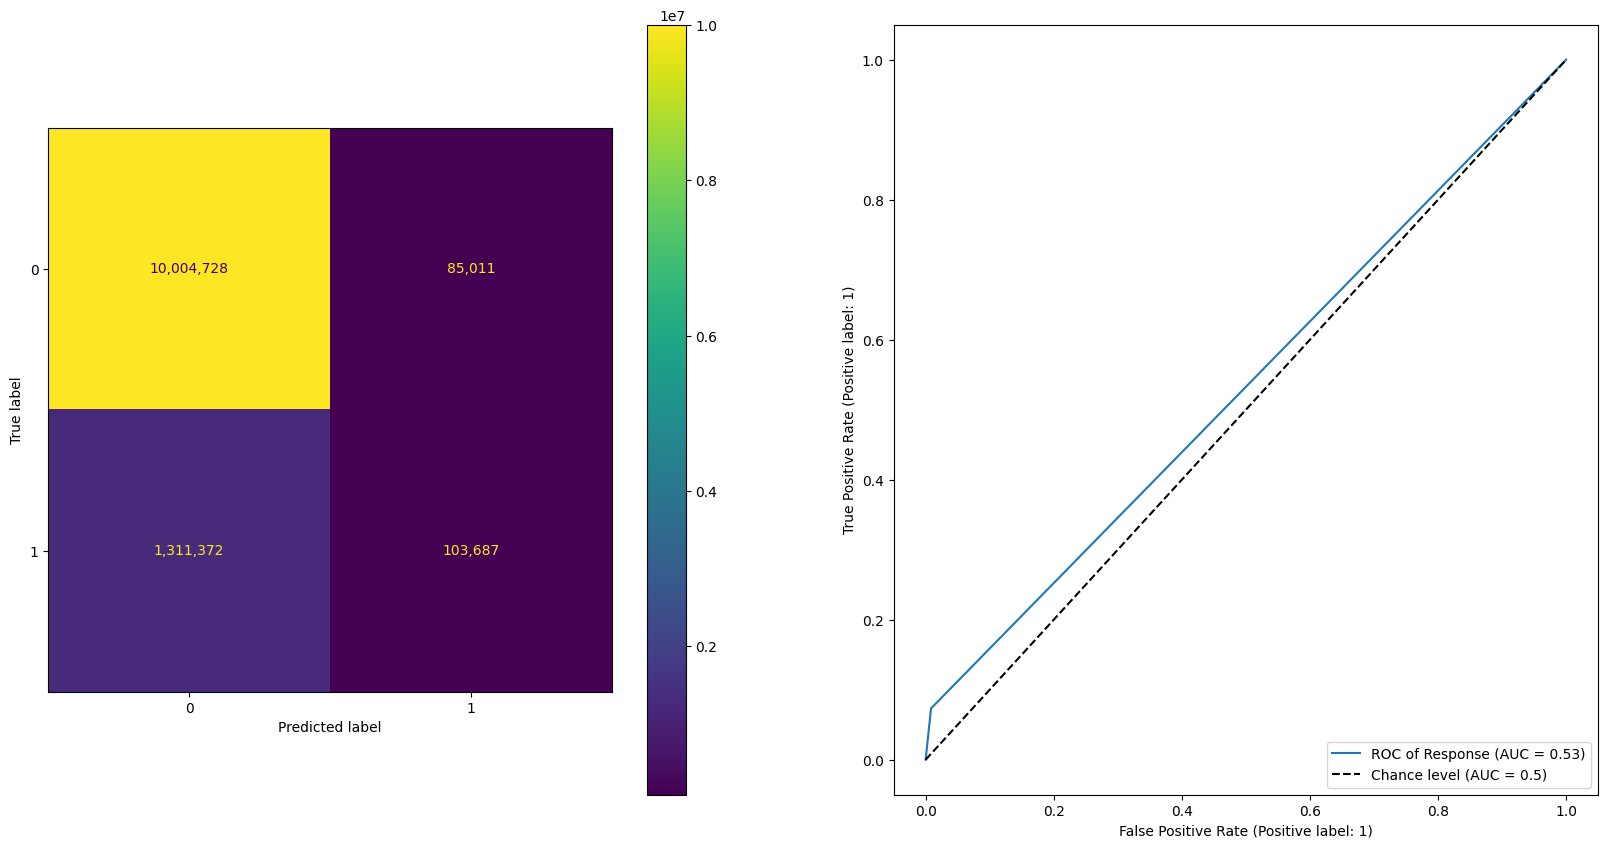

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

cm = confusion_matrix(y, xgb_preds["preds"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[0], values_format=",")

disp = RocCurveDisplay.from_predictions(
    y,
    xgb_preds["preds"],
    name=f"ROC of Response",
    plot_chance_level=True,
    ax=ax[1]
)

In [85]:
train_df.groupby(["Response"], observed=False).value_counts()

ValueError: Product space too large to allocate arrays!